In [1]:
# this notebook attempts to combine datasets from various sources about country statistics
# Furthermore, the notebook also attempts to preprocess the data for forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Data loading stage

In [3]:
# read the time series data about corona infections, deaths and recoveries worldwide
data_infections = pd.read_csv('../data/time_series_covid_19_confirmed.csv')
data_infections = data_infections.rename(columns={'Country/Region': 'country'})

data_deaths = pd.read_csv('../data/time_series_covid_19_deaths.csv')
data_deaths = data_deaths.rename(columns={'Country/Region': 'country'})

data_recovered = pd.read_csv('../data/time_series_covid_19_recovered.csv')
data_recovered = data_recovered.rename(columns={'Country/Region': 'country'})


In [4]:
data_infections.head()

,Province/State,country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [5]:
def reshape_timeseries(data, name):
    # summarize latlong data by averaging over province and state
    agg_dict = {"Lat": "mean", "Long": "mean"}
    
    #sum over the rest
    for col in data.columns[4:]:
        agg_dict[col] = 'sum'
    
    data = data.groupby('country').agg(agg_dict).reset_index() 

    
    # transpose and convert to proper time-series format
    data = data.set_index('country')
    data_timeseries_unstacked = data.iloc[:, 4:].transpose().unstack().reset_index()
    data = data.reset_index()
    result = pd.merge(data_timeseries_unstacked, data[['country', 'Lat', 'Long']], on="country")
    
    result = result.rename(columns={'level_1': 'date', 0: name})
    
    return result
    

In [6]:
data_infections = reshape_timeseries(data_infections, 'infections')
data_deaths = reshape_timeseries(data_deaths, 'deaths')
data_recovered = reshape_timeseries(data_recovered, 'recovered')

In [7]:
data_infections.head()

,country,date,infections,Lat,Long
0,Afghanistan,1/24/20,0,33.0,65.0
1,Afghanistan,1/25/20,0,33.0,65.0
2,Afghanistan,1/26/20,0,33.0,65.0
3,Afghanistan,1/27/20,0,33.0,65.0
4,Afghanistan,1/28/20,0,33.0,65.0


In [8]:
data_deaths.head()

,country,date,deaths,Lat,Long
0,Afghanistan,1/24/20,0,33.0,65.0
1,Afghanistan,1/25/20,0,33.0,65.0
2,Afghanistan,1/26/20,0,33.0,65.0
3,Afghanistan,1/27/20,0,33.0,65.0
4,Afghanistan,1/28/20,0,33.0,65.0


In [9]:
data_recovered.head()

,country,date,recovered,Lat,Long
0,Afghanistan,1/24/20,0,33.0,65.0
1,Afghanistan,1/25/20,0,33.0,65.0
2,Afghanistan,1/26/20,0,33.0,65.0
3,Afghanistan,1/27/20,0,33.0,65.0
4,Afghanistan,1/28/20,0,33.0,65.0


In [10]:
data = pd.concat([data_infections, data_deaths['deaths'], data_recovered['recovered']], axis=1)

In [11]:
# rename 'US' to 'United States'
data['country'] = data.country.str.replace('US', 'United States')

In [12]:
#for country in data['country'].unique():
#    print(country, (data['country'] == country).sum())

In [13]:
# read the data about medical capacity per country
data_beds = pd.read_csv("../data/beds_per_country.csv")
data_beds = data_beds.rename(columns={'Country/territory': 'country'})
data_beds.head()

,Rank,country,Continent,2013,2014,2015,2016,2017,Actual,Proportional (%),Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants"
0,1,Japan,Asia,13.30,13.21,13.17,13.11,13.05,−0.06,−0.48,75.5,NaN
1,2,South Korea,Asia,10.92,11.59,11.61,11.98,12.27,0.34,2.85,NaN,NaN
2,3,Russia,Europe,9.07,8.81,8.35,8.16,8.05,−0.26,−3.04,NaN,NaN
3,4,Germany,Europe,8.28,8.23,8.13,8.06,8.00,−0.07,−0.86,79.8,29.2[3]
4,5,Austria,Europe,7.64,7.58,7.54,7.42,7.37,−0.07,−0.90,73.8,21.8[3]


In [14]:
# read the data about population by country
data_pop = pd.read_csv("../data/population_by_country.csv")
data_pop = data_pop.rename(columns={'Country (or dependent territory)': 'country'})
data_pop.head()

,Rank,country,Population,% of worldpopulation,Date,Source
0,1,China[b],"1,401,812,360",18.0%,18 Mar 2020,National population clock[3]
1,2,India,"1,359,933,123",17.5%,18 Mar 2020,National population clock[4]
2,3,United States[c],"329,470,935",4.24%,18 Mar 2020,National population clock[5]
3,4,Indonesia,"266,911,900",3.43%,1 Jul 2019,National annual projection[6]
4,5,Pakistan,"218,983,520",2.82%,18 Mar 2020,2017 census[7]


In [15]:
# read data about latitude and longitude of countries
#data_latlong = pd.read_csv("../data/time_series_covid_19_confirmed.csv")
#data_latlong = data_latlong[['Country/Region', 'Lat', 'Long']]
#data_latlong = data_latlong.rename(columns={'Country/Region': 'country'})
#print(data_latlong.shape)
#data_latlong.head()

In [16]:
# read data bout age-distribution per country
data_age = pd.read_csv("../data/age_per_country.csv")
data_age = data_age.rename(columns={'Country': 'country'})
data_age.head()

,country,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
0,Afghanistan,43.2 %,54.2 %,2.6 %
1,Albania,17.4 %,68.9 %,13.2 %
2,Algeria,29.3 %,64.5 %,6.2 %
3,Angola,46.8 %,50.8 %,2.4 %
4,Antigua and Barbuda,23.9 %,69.2 %,6.9 %


<h2>Data filtering stage

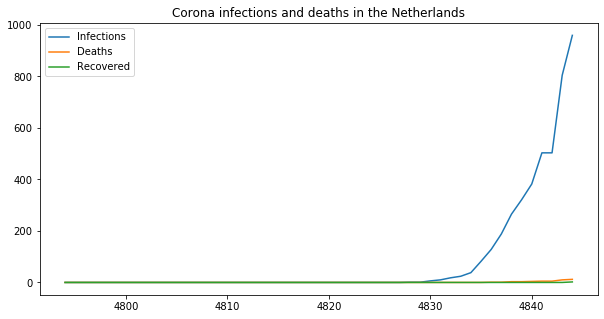

In [17]:
# plot the progression of infections and deaths in the Netherlands
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)
data[data['country'] == "Netherlands"]['infections'].plot(ax=ax)
data[data['country'] == "Netherlands"]['deaths'].plot(ax=ax)
data[data['country'] == "Netherlands"]['recovered'].plot(ax=ax)
plt.title("Corona infections and deaths in the Netherlands")
plt.legend(['Infections', 'Deaths', 'Recovered'])

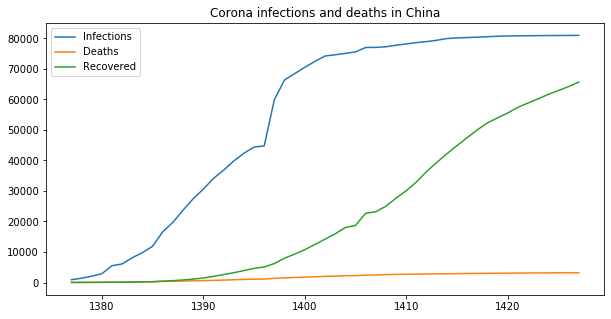

In [18]:
# plot the progression of infections and deaths in China
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)
data[data['country'] == "China"]['infections'].plot(ax=ax)
data[data['country'] == "China"]['deaths'].plot(ax=ax)
data[data['country'] == "China"]['recovered'].plot(ax=ax)
plt.title("Corona infections and deaths in China")
plt.legend(['Infections', 'Deaths', 'Recovered'])

In [19]:
# rename 'United Kingdom (more)' to 'United Kingdom'
data_beds['country'] = data_beds['country'].str.replace(r" \(.*\)", "")

# identify the countries occurring in the hospital data
data_beds['country'].unique()

array(['Japan', 'South Korea', 'Russia', 'Germany', 'Austria', 'Hungary',
       'Czech Republic', 'Poland', 'Lithuania', 'France', 'Slovakia',
       'Belgium', 'Latvia', 'Hong Kong', 'Estonia', 'Luxembourg',
       'Switzerland', 'Slovenia', 'China', 'Greece', 'Australia',
       'Norway', 'Portugal', 'Netherlands', 'Finland', 'Italy', 'Iceland',
       'Israel', 'Spain', 'Ireland', 'Turkey', 'United States',
       'New Zealand', 'Denmark', 'United Kingdom', 'Canada', 'Sweden',
       'Chile', 'Colombia', 'Mexico'], dtype=object)

In [20]:
data['country'] = data['country'].str.replace(r" \(.*\)", "").str.replace("*", "")

In [21]:
# identify the countries occurring in the timeseries data
data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France',
       'French Guiana', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Guadeloupe', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana',
       'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea, Sou

In [22]:
# compute the overlap between the two sets
countries = np.intersect1d(data['country'], data_beds['country'])
countries, countries.shape

(array(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'China',
        'Colombia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
        'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico',
        'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
        'Russia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
        'Turkey', 'United Kingdom', 'United States'], dtype=object),
 (37,))

In [23]:
# drop countries not in 'countries' array
def drop_unneeded_countries(data, countries):
    data['country'] = data.country.apply(lambda x: np.nan if x not in countries else x)
    # get indices of nonmissing
    data = data[~data['country'].isnull()]
    
    
    return data

In [24]:
# remove unneeded countries from all data
data = drop_unneeded_countries(data, countries)

In [25]:
#data_latlong = drop_unneeded_countries(data_latlong, countries)

In [26]:
# summarize lat long by mean for countries with multiple states/regions
#data_latlong = data_latlong.groupby('country').mean().reset_index()

In [27]:
data_beds = drop_unneeded_countries(data_beds, countries)

In [28]:
data_age = drop_unneeded_countries(data_age, countries)

In [29]:
# remove added tokens from country names
data_pop['country'].head()

0            China[b]
1               India
2    United States[c]
3           Indonesia
4            Pakistan
Name: country, dtype: object

In [30]:
data_pop['country'] = data_pop['country'].str.replace(r'\[.\]', '').str.replace('\s\(.*\)', '')

In [31]:
data_pop = drop_unneeded_countries(data_pop, countries)

<h2> Merging stage

In [32]:
# merge all the data by country
data = pd.merge(data, data_beds, on='country')

In [33]:
data = pd.merge(data, data_pop, on='country')

In [34]:
data = pd.merge(data, data_age, on='country')

In [35]:
# drop columns without value
data.columns

Index(['country', 'date', 'infections', 'Lat', 'Long', 'deaths', 'recovered',
       'Rank_x', 'Continent', '2013', '2014', '2015', '2016', '2017', 'Actual',
       'Proportional (%)', 'Occupancy (%)[2]',
       'ICU-CCB beds/100,000 inhabitants', 'Rank_y', 'Population',
       '% of worldpopulation', 'Date', 'Source', 'age 0 to 14 years[1]',
       'age 15 to 64 years[2]', 'age over 65 years[3]'],
      dtype='object')

In [36]:
#data = data.drop(['GeoId', 'Actual', 'Proportional (%)', 'Rank_x', 'Rank_y', 'Date', 'Source'], axis=1)
data = data.drop(['Actual', 'Proportional (%)', 'Rank_x', 'Rank_y', 'Date', 'Source'], axis=1)

In [37]:
data[data['country'] == "Netherlands"].head()

,country,date,infections,Lat,Long,deaths,recovered,Continent,2013,2014,2015,2016,2017,Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants",Population,% of worldpopulation,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
1173,Netherlands,1/24/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1174,Netherlands,1/25/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1175,Netherlands,1/26/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1176,Netherlands,1/27/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1177,Netherlands,1/28/20,0,52.1326,5.2913,0,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %


In [38]:
data[data['country'] == "Netherlands"].tail()

,country,date,infections,Lat,Long,deaths,recovered,Continent,2013,2014,2015,2016,2017,Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants",Population,% of worldpopulation,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
1219,Netherlands,3/10/20,382,52.1326,5.2913,4,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1220,Netherlands,3/11/20,503,52.1326,5.2913,5,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1221,Netherlands,3/12/20,503,52.1326,5.2913,5,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1222,Netherlands,3/13/20,804,52.1326,5.2913,10,0,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %
1223,Netherlands,3/14/20,959,52.1326,5.2913,12,2,Europe,4.18,NaN,3.52,3.44,3.32,65.4,6.4[3],"17,445,781",0.224%,16.4 %,64.8 %,18.8 %


<h2>Cleaning stage

In [39]:
# remove percentage symbol from columns and convert to numeric
data['% of worldpopulation'] = data['% of worldpopulation'].str.replace('%', '').astype(float) / 100

In [40]:
data['age 0 to 14 years[1]'] = data['age 0 to 14 years[1]'].str.replace('%', '').astype(float) / 100

In [41]:
data['age 15 to 64 years[2]'] = data['age 15 to 64 years[2]'].str.replace('%', '').astype(float) / 100

In [42]:
data['age over 65 years[3]'] = data['age over 65 years[3]'].str.replace('%', '').astype(float) / 100

In [43]:
# divide percent value by 100
data['Occupancy (%)[2]'] = data['Occupancy (%)[2]'] / 100

In [44]:
# drop year columns (for now)
data = data.drop(['2013', '2014', '2015', '2016','2017'], axis=1)

In [45]:
# convert 'Population' column to numeric
data['Population'] = data['Population'].str.replace(',', '').str.replace('.', '').astype(float)

In [46]:
data[data['country'] == "Netherlands"].tail()

,country,date,infections,Lat,Long,deaths,recovered,Continent,Occupancy (%)[2],"ICU-CCB beds/100,000 inhabitants",Population,% of worldpopulation,age 0 to 14 years[1],age 15 to 64 years[2],age over 65 years[3]
1219,Netherlands,3/10/20,382,52.1326,5.2913,4,0,Europe,0.654,6.4[3],17445781.0,0.00224,0.164,0.648,0.188
1220,Netherlands,3/11/20,503,52.1326,5.2913,5,0,Europe,0.654,6.4[3],17445781.0,0.00224,0.164,0.648,0.188
1221,Netherlands,3/12/20,503,52.1326,5.2913,5,0,Europe,0.654,6.4[3],17445781.0,0.00224,0.164,0.648,0.188
1222,Netherlands,3/13/20,804,52.1326,5.2913,10,0,Europe,0.654,6.4[3],17445781.0,0.00224,0.164,0.648,0.188
1223,Netherlands,3/14/20,959,52.1326,5.2913,12,2,Europe,0.654,6.4[3],17445781.0,0.00224,0.164,0.648,0.188


In [47]:
data['ICU-CCB beds/100,000 inhabitants'] = data['ICU-CCB beds/100,000 inhabitants'].str.replace(r"\[.*\]", "")

In [48]:
data['ICU-CCB beds/100,000 inhabitants'] = data['ICU-CCB beds/100,000 inhabitants'].str.replace(r"\[.+\]\[.+\]", "").astype(float)

In [49]:
# give columns easier names
data = data.rename(columns={'Lat_x': "latitude", 
                             'Long_x': 'longitude', 
                             'Occupancy (%)[2]': 'bed_occupancy',
                             'ICU-CCB beds/100,000 inhabitants':'ICU_beds',
                             '% of worldpopulation': 'population_world',
                            'age 0 to 14 years[1]': 'age_0_to_64',
                            'age 15 to 64 years[2]': 'age_15_to_64',
                            'age over 65 years[3]': 'age_over_65'})

In [50]:
data[data['country'] == "Netherlands"].tail()

,country,date,infections,Lat,Long,deaths,recovered,Continent,bed_occupancy,ICU_beds,Population,population_world,age_0_to_64,age_15_to_64,age_over_65
1219,Netherlands,3/10/20,382,52.1326,5.2913,4,0,Europe,0.654,6.4,17445781.0,0.00224,0.164,0.648,0.188
1220,Netherlands,3/11/20,503,52.1326,5.2913,5,0,Europe,0.654,6.4,17445781.0,0.00224,0.164,0.648,0.188
1221,Netherlands,3/12/20,503,52.1326,5.2913,5,0,Europe,0.654,6.4,17445781.0,0.00224,0.164,0.648,0.188
1222,Netherlands,3/13/20,804,52.1326,5.2913,10,0,Europe,0.654,6.4,17445781.0,0.00224,0.164,0.648,0.188
1223,Netherlands,3/14/20,959,52.1326,5.2913,12,2,Europe,0.654,6.4,17445781.0,0.00224,0.164,0.648,0.188


In [51]:
# extract month and day from date column
data['month'] = data['date'].str.extract('(.)/').astype(float)

In [52]:
data['day'] = data['date'].str.extract('./(.+)/.').astype(float)

In [53]:
data.to_csv('../data/COVID19_timeseries.csv', index=None)

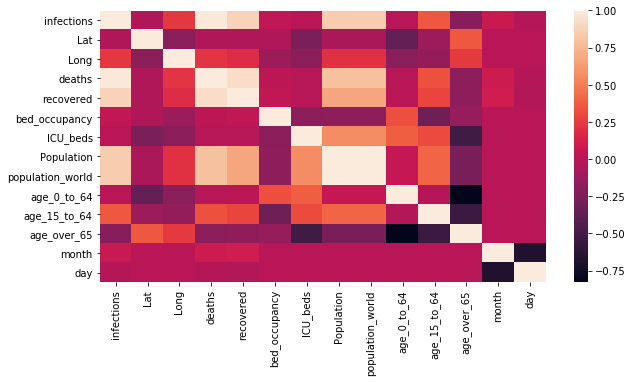

In [54]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr())

In [55]:
data.shape

(1887, 17)

In [56]:
data.country.unique()

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'China',
       'Colombia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico',
       'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
       'Russia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Turkey', 'United States', 'United Kingdom'], dtype=object)